<a href="https://colab.research.google.com/github/waltatgit/deeplearning/blob/master/text_classification_gru_lstm_conv1_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.3.0


In [4]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFS782V/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFS782V/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFS782V/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120, 64)           9600      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 188,813
Trainable params: 188,813
Non-trainable params: 0
________________________________________________

In [14]:
num_epochs = 50
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), callbacks=[es])

Epoch 1/50
782/782 [==============================] - 25s 32ms/step - loss: 0.5353 - accuracy: 0.7138 - val_loss: 0.3577 - val_accuracy: 0.8431
Epoch 2/50
782/782 [==============================] - 24s 31ms/step - loss: 0.3357 - accuracy: 0.8588 - val_loss: 0.3447 - val_accuracy: 0.8509
Epoch 3/50
782/782 [==============================] - 25s 31ms/step - loss: 0.2771 - accuracy: 0.8880 - val_loss: 0.3473 - val_accuracy: 0.8488
Epoch 4/50
782/782 [==============================] - 24s 31ms/step - loss: 0.2469 - accuracy: 0.9010 - val_loss: 0.3619 - val_accuracy: 0.8443
Epoch 5/50
782/782 [==============================] - 25s 32ms/step - loss: 0.2204 - accuracy: 0.9134 - val_loss: 0.4149 - val_accuracy: 0.8370
Epoch 6/50
782/782 [==============================] - 25s 32ms/step - loss: 0.1976 - accuracy: 0.9236 - val_loss: 0.4053 - val_accuracy: 0.8385
Epoch 7/50
782/782 [==============================] - 24s 31ms/step - loss: 0.1829 - accuracy: 0.9292 - val_loss: 0.4272 - val_accuracy:

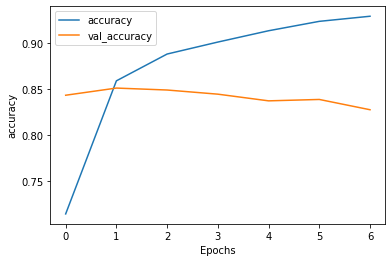

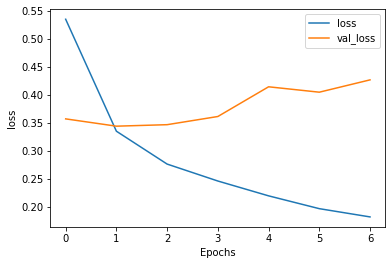

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [16]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 120, 64)           12544     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 197,773
Trainable params: 197,773
Non-trainable params: 0
________________________________________________

In [17]:
num_epochs = 50
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5)
history_lstm = model_lstm.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), callbacks=[es])

Epoch 1/50
782/782 [==============================] - 26s 33ms/step - loss: 0.4989 - accuracy: 0.7389 - val_loss: 0.3941 - val_accuracy: 0.8344
Epoch 2/50
782/782 [==============================] - 24s 31ms/step - loss: 0.3227 - accuracy: 0.8651 - val_loss: 0.3526 - val_accuracy: 0.8413
Epoch 3/50
782/782 [==============================] - 25s 31ms/step - loss: 0.2744 - accuracy: 0.8894 - val_loss: 0.3634 - val_accuracy: 0.8430
Epoch 4/50
782/782 [==============================] - 24s 31ms/step - loss: 0.2406 - accuracy: 0.9034 - val_loss: 0.3777 - val_accuracy: 0.8374
Epoch 5/50
782/782 [==============================] - 25s 32ms/step - loss: 0.2130 - accuracy: 0.9148 - val_loss: 0.3965 - val_accuracy: 0.8356
Epoch 6/50
782/782 [==============================] - 25s 32ms/step - loss: 0.1913 - accuracy: 0.9240 - val_loss: 0.4521 - val_accuracy: 0.8305
Epoch 7/50
782/782 [==============================] - 25s 32ms/step - loss: 0.1738 - accuracy: 0.9328 - val_loss: 0.4294 - val_accuracy:

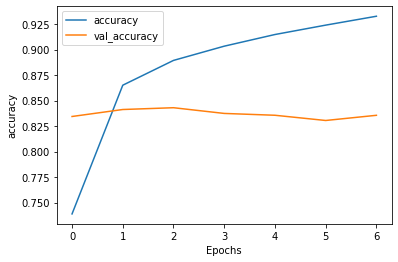

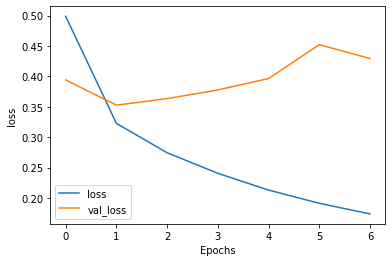

In [18]:


plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [19]:
# Model Definition with Conv1D
model_conv1d = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_conv1d.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_conv1d.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 50
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5)
history_conv1d = model_conv1d.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final), callbacks=[es])

Epoch 1/50
782/782 [==============================] - 6s 7ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
782/782 [==============================] - 5s 7ms/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
782/782 [==============================] - 5s 7ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/50
782/782 [==============================] - 5s 7ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 

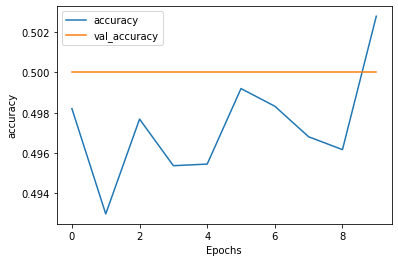

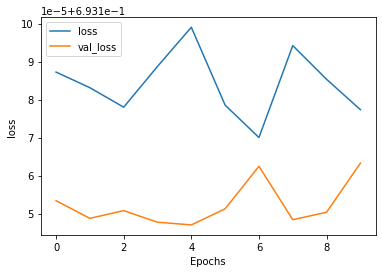

In [21]:
plot_graphs(history_conv1d, 'accuracy')
plot_graphs(history_conv1d, 'loss')